In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [5]:
from surprise import Reader, Dataset, SVD

In [6]:
# Read data
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
links_small = pd.read_csv('links_small.csv')
md = pd.read_csv('movies_metadata.csv')
ratings = pd.read_csv('ratings_small.csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\81844242.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('movies_metadata.csv')


## Credits DataFarme

In [7]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [8]:
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [9]:
# cast : information about casting
# crew : Information about crew number
# id : It's movie ID given by TMDb

In [10]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


### Keywords Dataframe

In [11]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [12]:
# id : It's movie ID given by TMDb
# keywords : list tags/key words for the movie

In [13]:
keywords.shape

(46419, 2)

### Link Dataframe

In [14]:
links_small

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [15]:
# movieId: It's serial number for movie
# imdbId: Movie id given on IMDb platform
# tmdbId: Movie id given on TMDb platform

### Metadata Dataframe

In [16]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [17]:
md.iloc[0:3].transpose()

,0,1,2
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect..."
budget,30000000,65000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
homepage,http://toystory.disney.com/toy-story,NaN,NaN
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
original_language,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...


In [18]:
md['vote_average']

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45466, dtype: float64

In [19]:
md.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

- __adult__ : Indicates if the movie is adult.
- __belongs_to_collection__ : gives information on the movie series.
- __budget__ : the budget of the movie.
- __genres__ : list of genres in movie.
- __homepage__ : movie homepage link.
- __id__ : the ID of the movie.
- __imbd_id__ : the Id of the movie on IMBd platform.
- __original_language__ : original language of movie.
- __original_title__ : original title of the movie.
- __overview__ : summary of the movie.
- __popularity__ : The Popularity Score assigned by TMDB.
- __poster_path__ : the URL of the poster image.
- __production_company__ : list of production companies involved with the making of the movie.
- __production_country__ : list of countries where the movie was shot/produced in.
- __release_date__ : Theatrical release date of the movie.
- __revenue__ : revenue of the movie.
- __runtume__ : runtime of the movie.
- __spoken_languages__ : spoken languages in the film.
- __status__ : The status of the movie (Released, To Be Released, Announced, etc.)
- __tagline__ : The tagline of the movie.
- __title__ : the official title of the movie.
- __video__ : Indicates if there is a video present of the movie with TMDB.
- __vote_average__ : the vote average.
- __vote_count__ : vote count.

In [20]:
md.shape

(45466, 24)

In [21]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

### Ratings Dataframe

In [22]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [23]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

- __userId__ : user ID.
- __movieID__ : Id of the movie user rating.
- __rating__ : Rating grade of the user (from 0 to 5).
- __timestamp__ : Time stamp when rating has been given by user

In [24]:
md['genres']

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [25]:
# tien xu ly genres fill gia tri thieu chuyen doi string thanh list va chi lay moi genres
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else [])

In [26]:
md['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

__Build Weight_Rating(WR)__  
- in movie context :  
$$WR = (\frac{v}{v+m}.R) + (\frac{m}{m+v}.c)$$  
where,  
v la so vote cua bo phim  
m la so vote toi thieu can thiet de su dung  
R la so phieu bau trung binh  
C la so phieu bau trung binh tren ca tap du lieu  

In [27]:
# Tinh v
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')

# Tinh R
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')

# Tinh C
C = vote_averages.mean()

In [28]:
C

5.244896612406511

In [29]:
# lay m la quantile(0.95)
m = vote_counts.quantile(0.95)
m

434.0

In [30]:
# tien xu ly year sang dang nam
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)
md['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
45461     NaT
45462    2011
45463    2003
45464    1917
45465    2017
Name: year, Length: 45466, dtype: object

In [31]:
# loc ra nhung du lieu dat chuan de phan tich
qualified = md[(md['vote_count'] >= m) &
               (md['vote_count'].notnull()) &
               (md['vote_average'].notnull())][['title','year','vote_count','vote_average','popularity','genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


In [32]:
# xay dung ham tinh WR
def weight_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
# tao cot moi co chi so weight rating
qualified['weight_rate'] = qualified.apply(weight_rating, axis = 1)
qualified

,title,year,vote_count,vote_average,popularity,genres,weight_rate
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]",6.869770
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]",5.884891
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]",6.671675
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]",5.798701
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]",6.571348
...,...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]",6.261904
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]",5.722745
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]",6.757878
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]",5.825125


In [34]:
# sap xep theo chi so weight_rating
qualified = qualified.sort_values('weight_rate', ascending=False).head(250)

In [35]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,weight_rate
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [36]:
# xu ly de lay mot DataFrame moi ma moi dong chua chi mot genre
s = md.apply(lambda x : pd.Series(x['genres']), axis = 1).stack().reset_index(level=1, drop=True)
s.name = 'genres'
gen_md = md.drop('genres', axis=1).join(s)
gen_md.head(3).transpose()

,0,0,0
adult,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ...","{'id': 10194, 'name': 'Toy Story Collection', ..."
budget,30000000,30000000,30000000
homepage,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story,http://toystory.disney.com/toy-story
id,862,862,862
imdb_id,tt0114709,tt0114709,tt0114709
original_language,en,en,en
original_title,Toy Story,Toy Story,Toy Story
overview,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ..."
popularity,21.946943,21.946943,21.946943


In [37]:
# chon ra nhung bo phim co WR cao nhat (do hot cao nhat) voi tung the loai
def build_chart(genres, percentile = 0.85) :
    df = gen_md[gen_md['genres'] == genres]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] > m) &
                   (df['vote_count'].notnull()) &
                   (df['vote_average'].notnull())][['title','year','vote_count','vote_average','popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['weight_rate'] = qualified.apply(lambda x : ((x['vote_count']/(x['vote_count'] + m)) *x['vote_average']) + (m/(m + x['vote_count'])*C), axis = 1)

    qualified = qualified.sort_values('weight_rate', ascending=False).head(250)

    return qualified

### Top 15 Animation Movies

In [38]:
build_chart('Animation').head(15)

,title,year,vote_count,vote_average,popularity,weight_rate
359,The Lion King,1994,5520,8,21.605761,7.909339
5481,Spirited Away,2001,3968,8,41.048867,7.875933
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.772103
2884,Princess Mononoke,1997,2041,8,17.166725,7.771305
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.735274
40251,Your Name.,2016,1030,8,34.461252,7.589820
5553,Grave of the Fireflies,1988,974,8,0.010902,7.570962
19901,Paperman,2012,734,8,7.198633,7.465676
39386,Piper,2016,487,8,11.243161,7.285132
20779,Wolf Children,2012,483,8,10.249498,7.281198


### top 15 Roman Movies

In [39]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,weight_rate
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


## Content Based Recomendation system

### Vì tập dữ liệu quá lên nên em sẽ sử dụng small data(em đã thử sử dụng data đầy đủ nhưng chiều lớn quá không chạy được SVD ngay cả khi em đã sử dụng sparse matrix để build similarity matrix).

In [40]:
# lay tmdbID tu links_small
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [41]:
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int32

In [42]:
md['id'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: id, Length: 45466, dtype: bool

In [43]:
# tao ham de convert sang int
def convert_int(x) :
    try:
        return int(x)
    except:
        return np.nan

In [44]:
# convert id sang int va check null
md['id'] = md['id'].apply(convert_int)
md[md['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [45]:
# remove nhung id la NaN
md = md.drop([19730, 29503, 35587])

In [46]:
# lay small data tu metadata
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

### Try build using overview and tagline

In [47]:
# xu li description va tagline
smd['tagline'].fillna('', inplace=True)
smd['description'] = smd['overview'] + smd['tagline']
smd['description'].fillna('', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3634358109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['tagline'].fillna('', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3634358109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['description'] = smd['overview'] + smd['tagline']
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3634358109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [48]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40224,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011.0,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,From the mind behind Evangelion comes a hit la...
40503,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698.0,tt2531318,en,The Beatles: Eight Days a Week - The Touring Y...,"The band stormed Europe in 1963, and, in 1964,...",...,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,False,7.6,92.0,2016,"The band stormed Europe in 1963, and, in 1964,..."
44821,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[Adventure, Fantasy, Animation, Action, Family]",http://movies.warnerbros.com/pk3/,10991.0,tt0235679,ja,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000,When Molly Hale's sadness of her father's disa...
44826,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",0,"[Adventure, Fantasy, Animation, Science Fictio...",http://www.pokemon.com/us/movies/movie-pokemon...,12600.0,tt0287635,ja,劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）,"All your favorite Pokémon characters are back,...",...,75.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,,Pokémon 4Ever: Celebi - Voice of the Forest,False,5.7,82.0,2001,"All your favorite Pokémon characters are back,..."


In [49]:
# su dung tfidf de build ma tran tfidf voi description va su dung ca cac tu va cap tu
tf = TfidfVectorizer(analyzer='word',ngram_range=(1,2), min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [50]:
print(tfidf_matrix)

  (0, 14374)	0.12185152744271287
  (0, 135999)	0.13497681053459026
  (0, 78094)	0.13497681053459026
  (0, 70735)	0.13497681053459026
  (0, 173370)	0.13497681053459026
  (0, 263028)	0.13497681053459026
  (0, 32156)	0.13497681053459026
  (0, 211426)	0.13497681053459026
  (0, 40915)	0.13497681053459026
  (0, 32149)	0.13497681053459026
  (0, 182227)	0.13497681053459026
  (0, 263030)	0.13497681053459026
  (0, 108388)	0.13497681053459026
  (0, 10561)	0.13497681053459026
  (0, 180445)	0.13497681053459026
  (0, 143950)	0.13497681053459026
  (0, 6282)	0.13497681053459026
  (0, 207239)	0.13497681053459026
  (0, 139595)	0.13497681053459026
  (0, 32153)	0.1291687802417233
  (0, 29230)	0.13497681053459026
  (0, 24049)	0.13497681053459026
  (0, 10548)	0.13497681053459026
  (0, 203273)	0.13497681053459026
  (0, 106359)	0.13497681053459026
  :	:
  (9097, 137596)	0.048461572127086204
  (9097, 239488)	0.05798939970295126
  (9097, 52652)	0.050857909833882636
  (9097, 78310)	0.0379398695854721
  (9097, 26

In [51]:
tfidf_matrix.shape

(9099, 268124)

In [52]:
# su dung cosine_sim de danh gia do giong nhau giua cac movie
cosine_sim = cosine_similarity(tfidf_matrix)

In [53]:
cosine_sim[0][0]

1.0000000000000002

In [54]:
# tao ra Serise co index la title de su dung (chi can theo title khong can theo id)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [55]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
Shin Godzilla                                         9094
The Beatles: Eight Days a Week - The Touring Years    9095
Pokémon: Spell of the Unknown                         9096
Pokémon 4Ever: Celebi - Voice of the Forest           9097
Force Majeure                                         9098
Length: 9099, dtype: int64

In [56]:
# recommend system basic
def get_recommendation(title) :
    # lay index cua title
    idx = indices[title]
    # tao tuple cho cosine_sim
    sim_scores = list(enumerate(cosine_sim[idx]))
    # sap xep theo sim_score
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse = True)
    # lay 20 gia tri sim_score cao nhat (tru chinh no)
    sim_scores = sim_scores[1:21]
    #lay indices cua nhung bo phim kia
    movie_indicies = [i[0] for i in sim_scores]
    # tra ve 20 bo phim recommend
    return titles.iloc[movie_indicies]


Test với một vài bộ phim

In [57]:
get_recommendation('Toy Story')

2502                    Toy Story 2
7535                    Toy Story 3
6193         The 40 Year Old Virgin
2547                Man on the Moon
6627                   Factory Girl
4702         What's Up, Tiger Lily?
889           Rebel Without a Cause
6554         For Your Consideration
4988               Rivers and Tides
1599                      Condorman
994                       Manhattan
402               For Love or Money
5140                 Africa Screams
437                          Malice
6107                  Life Is Sweet
3097    The Ballad of Ramblin' Jack
1792              Indecent Proposal
8330     Woody Allen: A Documentary
4383              Maid in Manhattan
4935               A Midnight Clear
Name: title, dtype: object

## Improve conten-based

### Using more information about cast director genres

In [58]:
# Dieu chinh lai kieu du lieu
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [59]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [60]:
md.shape

(45463, 25)

Chúng ta sẽ merge bảng credits và keys word vào md để sử dụng

In [61]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [62]:
md.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [63]:
# su dung small_data
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

__1. Crew__ : From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.

__2. Cast__ : Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [64]:
# su dung literal_eval de chuyen string chua list sang list
smd['cast'] = smd['cast'].apply(literal_eval)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2376836059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(literal_eval)


In [65]:
smd['cast']

0        [{'cast_id': 14, 'character': 'Woody (voice)',...
1        [{'cast_id': 1, 'character': 'Alan Parrish', '...
2        [{'cast_id': 2, 'character': 'Max Goldman', 'c...
3        [{'cast_id': 1, 'character': 'Savannah 'Vannah...
4        [{'cast_id': 1, 'character': 'George Banks', '...
                               ...                        
40952    [{'cast_id': 1, 'character': 'Henry Cobb', 'cr...
41172    [{'cast_id': 0, 'character': 'Rustom Pavri', '...
41225    [{'cast_id': 0, 'character': 'Sarman', 'credit...
41391    [{'cast_id': 4, 'character': 'Rando Yaguchi : ...
41669    [{'cast_id': 0, 'character': 'Himself', 'credi...
Name: cast, Length: 9219, dtype: object

In [66]:
# xu li tuong tu voi crew va keywords
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
# them columns chua length cua cast va crew
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3921265049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['crew'] = smd['crew'].apply(literal_eval)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3921265049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(literal_eval)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3921265049.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [67]:
smd.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7


In [68]:
# viet function de lay director cua movie
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [69]:
# tao columns director
smd['director'] = smd['crew'].apply(get_director)
# lay name cua cac actor trong movie (chi lay 3 dien vien)
smd['cast'] = smd['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])
smd['cast'] = smd['cast'].apply(lambda x : x[:3] if len(x) > 3 else x)
# lay name cua keywords
smd['keywords'] = smd['keywords'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2676541571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['crew'].apply(get_director)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2676541571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x : [i['name'] for i in x] if isinstance(x,list) else [])
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2676541571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

- __Ta sẽ loại bỏ khoảng trắng và chuyển tất cả thành chữ thường__ với tất cả features. Bằng cách này thì model sẽ không nhầm lẫn giữa một vài diễn viên có thể có họ hoặc tên giống nhau  
- __Ta sẽ cho đạo diễn lặp lại 2 lần để tăng thêm weigth__

In [70]:
# convert to lower case and strip space
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
# lap lai director 3 lan
smd['director'] = smd['director'].apply(lambda x : [x,x,x])


C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3750319959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(' ', '')) for i in x])
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3750319959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3750319959.py:5: SettingWithCopyWarning: 
A value is tr

In [71]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,"[joejohnston, joejohnston, joejohnston]"
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,"[howarddeutch, howarddeutch, howarddeutch]"
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,"[charlesshyer, charlesshyer, charlesshyer]"


- Ta sẽ tiến hành tiền xử lí keywords
- Tính toán tần suất keywords xuất hiện của tập data 

In [72]:
# tao mot series moi dong chua mot keyword
s = smd.apply(lambda x : pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keywords'
# bien s thanh Series chua tan so cua tung tu trong data
s = s.value_counts()
s[:5]

keywords
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

- Keywords occur frequency from 1 to 610.
- We don't use the keywords that occur only once.
- Finally, we will convert every word to its stem. 

In [73]:
# lay nhung keywords xuat hien hon 1 lan
s = s[s>1]

In [74]:
s

keywords
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
                       ... 
boarder                   2
social climbing           2
covert operation          2
prisoners                 2
crystal                   2
Name: count, Length: 6709, dtype: int64

In [75]:
steammer = SnowballStemmer('english')
steammer.stem('cats')

'cat'

In [76]:
# function loc nhung keywords xuat hien 1 lan
def get_filtered_word(x) :
    words = []
    for i in x:
        if i in s :
            words.append(i)
    return words

In [77]:
# loc keywords
smd['keywords'] = smd['keywords'].apply(get_filtered_word)
# su dung steammer de convert ve tu goc
smd['keywords'] = smd['keywords'].apply(lambda x : [steammer.stem(i) for i in x])
# 
smd['keywords'] = smd['keywords'].apply(lambda x : [str.lower(i.replace(' ','')) for i in x])

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2729757571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(get_filtered_word)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2729757571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['keywords'] = smd['keywords'].apply(lambda x : [steammer.stem(i) for i in x])
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2729757571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [78]:
smd['keywords']

0        [jealousi, toy, boy, friendship, friend, rival...
1        [boardgam, disappear, basedonchildren'sbook, n...
2                   [fish, bestfriend, duringcreditssting]
3        [basedonnovel, interracialrelationship, single...
4        [babi, midlifecrisi, confid, age, daughter, mo...
                               ...                        
40952                                         [friendship]
41172                                          [bollywood]
41225                                          [bollywood]
41391     [monster, godzilla, giantmonst, destruct, kaiju]
41669                                 [music, documentari]
Name: keywords, Length: 9219, dtype: object

In [79]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x : ' '.join(x))

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3346222905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3346222905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smd['soup'] = smd['soup'].apply(lambda x : ' '.join(x))


In [80]:
smd

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,False,NaN,8000000,[Drama],NaN,159550,tt0255313,en,The Last Brickmaker in America,A man must cope with the loss of his wife and ...,...,7.0,1.0,2001,"[sidneypoitier, wendycrewson, jayo.sanders]","[{'credit_id': '544475aac3a36819fb000578', 'de...",[friendship],7,2,"[greggchampion, greggchampion, greggchampion]",friendship sidneypoitier wendycrewson jayo.san...
41172,False,NaN,1000000,"[Thriller, Romance]",NaN,392572,tt5165344,hi,रुस्तम,"Rustom Pavri, an honourable officer of the Ind...",...,7.3,25.0,2016,"[akshaykumar, ileanad'cruz, eshagupta]","[{'credit_id': '5951baf692514129c4016600', 'de...",[bollywood],14,16,"[tinusureshdesai, tinusureshdesai, tinusureshd...",bollywood akshaykumar ileanad'cruz eshagupta t...
41225,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj...",...,6.7,26.0,2016,"[hrithikroshan, poojahegde, kabirbedi]","[{'credit_id': '57cd5d3592514179d50018e8', 'de...",[bollywood],12,16,"[ashutoshgowariker, ashutoshgowariker, ashutos...",bollywood hrithikroshan poojahegde kabirbedi a...
41391,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,シン・ゴジラ,From the mind behind Evangelion comes a hit la...,...,6.6,152.0,2016,"[hirokihasegawa, yutakatakenouchi, satomiishih...","[{'credit_id': '560892fa92514177550018b2', 'de...","[monster, godzilla, giantmonst, destruct, kaiju]",49,27,"[hideakianno, hideakianno, hideakianno]",monster godzilla giantmonst destruct kaiju hir...


In [81]:
count = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=0.0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [82]:
print(count_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [83]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [84]:
print(cosine_sim)

[[1.         0.02441931 0.02738955 ... 0.         0.         0.        ]
 [0.02441931 1.         0.         ... 0.02973505 0.02500782 0.        ]
 [0.02738955 0.         1.         ... 0.03335187 0.         0.        ]
 ...
 [0.         0.02973505 0.03335187 ... 1.         0.08700222 0.        ]
 [0.         0.02500782 0.         ... 0.08700222 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [85]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [86]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

In [87]:
get_recommendation('The Dark Knight')

8031                 The Dark Knight Rises
6218                         Batman Begins
6623                          The Prestige
2085                             Following
7648                             Inception
4145                              Insomnia
3381                               Memento
8613                          Interstellar
7659            Batman: Under the Red Hood
1134                        Batman Returns
8927               Kidnapping Mr. Heineken
5943                              Thursday
1260                        Batman & Robin
9024    Batman v Superman: Dawn of Justice
4021                  The Long Good Friday
5809                           Point Blank
7362       Gangster's Paradise: Jerusalema
7561                           Harry Brown
7582                              Defendor
8001                      Batman: Year One
Name: title, dtype: object

__Improvement__

- We can trying another parameter in actor, genres, director...

In [88]:
get_recommendation('Inception').head(10)

6623                             The Prestige
3381                                  Memento
4145                                 Insomnia
2085                                Following
8031                    The Dark Knight Rises
8613                             Interstellar
6981                          The Dark Knight
6218                            Batman Begins
5638    Sky Captain and the World of Tomorrow
8500                                  Don Jon
Name: title, dtype: object

__Add popular and rating__

- We should not recommend a bad film even their have a lot similarity charactors 
- We will add a mechanic to remove bad movies and recommend which are popular and had a good rating

In [89]:
def improved_recomendation(title) :
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x : x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movies_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movies_indices][['title','vote_count','vote_average','year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) &
                       (movies['vote_count'].notnull()) &
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['weight_rate'] = qualified.apply(weight_rating, axis=1)
    qualified = qualified.sort_values('weight_rate', ascending=False).head(10)
    return qualified

In [90]:
improved_recomendation('The Dark Knight')

C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3381523040.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3381523040.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\3381523040.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,title,vote_count,vote_average,year,weight_rate
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


### Test CF Using SVD

In [91]:
reader = Reader()

In [92]:
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

In [93]:
model = SVD()

In [94]:
results = cross_validate(model,data, measures=['RMSE','MAE'], cv = 5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8947  0.8913  0.9003  0.8998  0.8986  0.8969  0.0034  
MAE (testset)     0.6900  0.6866  0.6913  0.6919  0.6914  0.6903  0.0019  
Fit time          0.85    0.80    0.77    0.74    0.76    0.78    0.04    
Test time         0.10    0.10    0.24    0.09    0.10    0.13    0.06    


In [95]:
train_set = data.build_full_trainset()
model.fit(train_set)

In [96]:
model.test(train_set.build_testset())

[Prediction(uid=1, iid=31, r_ui=2.5, est=2.348348100158176, details={'was_impossible': False}),
 Prediction(uid=1, iid=1029, r_ui=3.0, est=2.7425185423451017, details={'was_impossible': False}),
 Prediction(uid=1, iid=1061, r_ui=3.0, est=2.7811701528814496, details={'was_impossible': False}),
 Prediction(uid=1, iid=1129, r_ui=2.0, est=2.3995159898036285, details={'was_impossible': False}),
 Prediction(uid=1, iid=1172, r_ui=4.0, est=3.6684085146200305, details={'was_impossible': False}),
 Prediction(uid=1, iid=1263, r_ui=2.0, est=2.713420978226597, details={'was_impossible': False}),
 Prediction(uid=1, iid=1287, r_ui=2.0, est=2.8596942258084557, details={'was_impossible': False}),
 Prediction(uid=1, iid=1293, r_ui=2.0, est=2.996689131189052, details={'was_impossible': False}),
 Prediction(uid=1, iid=1339, r_ui=3.5, est=2.705330117893138, details={'was_impossible': False}),
 Prediction(uid=1, iid=1343, r_ui=2.0, est=2.7386646458790347, details={'was_impossible': False}),
 Prediction(uid=

In [97]:
train_set

In [98]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [99]:
model.predict(1,301)

Prediction(uid=1, iid=301, r_ui=None, est=2.8222621326775905, details={'was_impossible': False})

## Test Item based collab

In [100]:
small_movies = md

In [101]:
small_movies.rename(columns={'id' : 'movieId'}, inplace=True)

In [102]:
small_movies

,adult,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46623,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...","[{'id': 10703, 'name': 'tragic love'}]"
46624,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,Released,NaN,Century of Birthing,False,9.0,3.0,2011,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...","[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46625,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",[]
46626,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,Released,NaN,Satan Triumphant,False,0.0,0.0,1917,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",[]


In [103]:
df1 = pd.merge(ratings, small_movies, on='movieId', how = 'inner')

In [104]:
df1

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,imdb_id,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,1,1371,2.5,1260759135,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,[Drama],NaN,tt0084602,...,Released,The greatest challenge.,Rocky III,False,6.6,894.0,1982,"[{'cast_id': 21, 'character': 'Rocky Balboa', ...","[{'credit_id': '52fe42f0c3a36847f802e4d1', 'de...","[{'id': 396, 'name': 'transporter'}, {'id': 14..."
1,4,1371,4.0,949810302,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,[Drama],NaN,tt0084602,...,Released,The greatest challenge.,Rocky III,False,6.6,894.0,1982,"[{'cast_id': 21, 'character': 'Rocky Balboa', ...","[{'credit_id': '52fe42f0c3a36847f802e4d1', 'de...","[{'id': 396, 'name': 'transporter'}, {'id': 14..."
2,7,1371,3.0,851869160,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,[Drama],NaN,tt0084602,...,Released,The greatest challenge.,Rocky III,False,6.6,894.0,1982,"[{'cast_id': 21, 'character': 'Rocky Balboa', ...","[{'credit_id': '52fe42f0c3a36847f802e4d1', 'de...","[{'id': 396, 'name': 'transporter'}, {'id': 14..."
3,19,1371,4.0,855193404,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,[Drama],NaN,tt0084602,...,Released,The greatest challenge.,Rocky III,False,6.6,894.0,1982,"[{'cast_id': 21, 'character': 'Rocky Balboa', ...","[{'credit_id': '52fe42f0c3a36847f802e4d1', 'de...","[{'id': 396, 'name': 'transporter'}, {'id': 14..."
4,21,1371,3.0,853852263,False,"{'id': 1575, 'name': 'Rocky Collection', 'post...",17000000,[Drama],NaN,tt0084602,...,Released,The greatest challenge.,Rocky III,False,6.6,894.0,1982,"[{'cast_id': 21, 'character': 'Rocky Balboa', ...","[{'credit_id': '52fe42f0c3a36847f802e4d1', 'de...","[{'id': 396, 'name': 'transporter'}, {'id': 14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45037,652,129009,4.0,1442690827,False,NaN,0,"[Comedy, Romance]",NaN,tt0057262,...,Released,The hilariously mad story of all the best thin...,Love Is a Ball,False,4.0,1.0,1963,"[{'cast_id': 2, 'character': 'John Lathrop Dav...","[{'credit_id': '562821a29251414cd20000fc', 'de...","[{'id': 9813, 'name': 'french riviera'}, {'id'..."
45038,653,2103,3.0,948161066,False,NaN,47000000,"[Drama, Science Fiction, Mystery, Romance]",NaN,tt0307479,...,Released,How far will you go for a second chance?,Solaris,False,5.9,378.0,2002,"[{'cast_id': 14, 'character': 'Chris Kelvin', ...","[{'credit_id': '52fe4336c3a36847f8042b77', 'de...","[{'id': 402, 'name': 'clone'}, {'id': 1565, 'n..."
45039,659,167,4.0,836137550,False,NaN,48000000,"[Drama, Science Fiction]",http://www.k-pax.com/,tt0272152,...,Released,Change the way you look at the world.,K-PAX,False,7.1,710.0,2001,"[{'cast_id': 2, 'character': 'Dr. Mark Powell'...","[{'credit_id': '52fe4221c3a36847f80065cb', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 1566, ..."
45040,659,563,3.0,834694187,False,"{'id': 10522, 'name': 'Starship Troopers Colle...",105000000,"[Adventure, Action, Thriller, Science Fiction]",NaN,tt0120201,...,Released,The only good bug is a dead bug.,Starship Troopers,False,6.7,1584.0,1997,"[{'cast_id': 21, 'character': 'Johnny Rico', '...","[{'credit_id': '52fe4253c3a36847f801557d', 'de...","[{'id': 305, 'name': 'moon'}, {'id': 1423, 'na..."


In [105]:
agg_ratings = df1.groupby('title').agg(mean_rating = ('rating','mean'), number_of_rating = ('rating','count')).reset_index()

In [106]:
agg_ratings_50 = agg_ratings[agg_ratings['number_of_rating'] > 200]

In [107]:
agg_ratings_50

,title,mean_rating,number_of_rating
573,Dawn of the Dead,4.014423,208
1210,License to Wed,4.178218,202
1331,Men in Black II,4.256696,224
1374,Monsoon Wedding,3.706204,274
1506,Once Were Warriors,4.303279,244
1807,Silent Hill,3.674419,215
1816,Sissi,3.953052,213
1837,Solaris,4.134426,305
1959,Terminator 3: Rise of the Machines,4.256173,324
1967,The 39 Steps,4.221649,291


c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

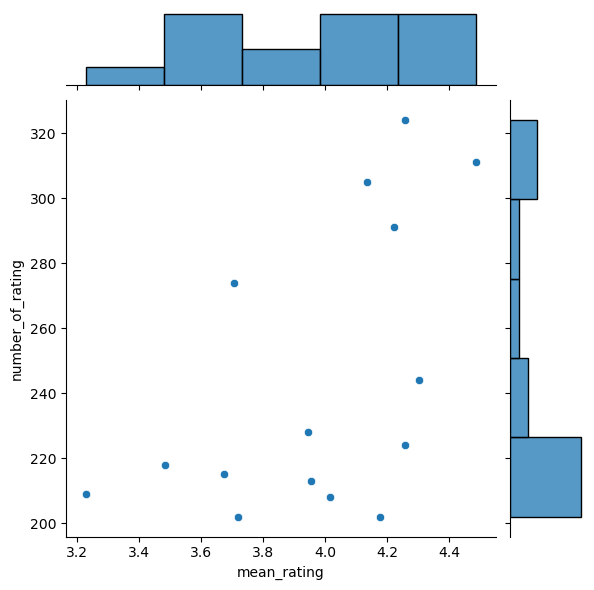

In [108]:
sns.jointplot(x = 'mean_rating', y='number_of_rating', data = agg_ratings_50)

In [109]:
df_GT50 = pd.merge(df1, agg_ratings_50[['title']], on='title', how='inner')

In [110]:
df_GT50

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,imdb_id,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,2,110,4.0,835355532,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
1,3,110,4.0,1298922049,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
2,7,110,5.0,851868188,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
3,8,110,4.0,1154473268,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
4,13,110,4.0,1331380038,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663,659,608,5.0,847452089,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3664,667,608,5.0,847271510,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3665,668,608,5.0,993613478,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3666,670,608,5.0,938782093,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."


In [111]:
# build utility matrix
matrix = df_GT50.pivot_table(index='title', columns='userId', values='rating')

In [112]:
matrix

userId,2,3,4,5,7,8,9,10,11,12,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
Dawn of the Dead,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
License to Wed,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,NaN,4.0
Men in Black II,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,5.0,4.0
Monsoon Wedding,4.0,NaN,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,3.0,3.5,3.5,NaN,4.0,4.0,NaN,3.0,NaN,NaN
Once Were Warriors,4.0,3.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,5.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,5.0,NaN
Silent Hill,3.0,3.0,5.0,3.5,4.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,4.0
Sissi,3.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,...,4.0,NaN,3.5,3.0,3.0,3.0,NaN,NaN,4.0,4.0
Solaris,3.0,3.0,NaN,NaN,NaN,4.5,4.0,NaN,NaN,NaN,...,NaN,4.0,4.5,4.0,4.0,NaN,5.0,NaN,5.0,NaN
Terminator 3: Rise of the Machines,4.0,4.5,5.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,...,3.0,NaN,5.0,4.0,4.0,5.0,5.0,NaN,NaN,4.0


In [113]:
# normalization the utility matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1),axis=0)
matrix_norm

userId,2,3,4,5,7,8,9,10,11,12,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
Dawn of the Dead,NaN,NaN,NaN,NaN,0.047840,NaN,NaN,NaN,1.047840,NaN,...,NaN,NaN,0.047840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
License to Wed,NaN,0.821782,NaN,NaN,NaN,-0.178218,NaN,NaN,NaN,-0.178218,...,NaN,NaN,0.821782,0.821782,NaN,NaN,NaN,0.821782,NaN,-0.178218
Men in Black II,NaN,NaN,NaN,NaN,NaN,NaN,0.743304,NaN,NaN,-2.256696,...,NaN,NaN,NaN,NaN,NaN,0.743304,0.743304,NaN,0.743304,-0.256696
Monsoon Wedding,0.293796,NaN,1.293796,NaN,0.293796,NaN,NaN,NaN,NaN,NaN,...,-0.706204,-0.206204,-0.206204,NaN,0.293796,0.293796,NaN,-0.706204,NaN,NaN
Once Were Warriors,-0.303279,-1.303279,NaN,NaN,NaN,0.696721,0.696721,NaN,NaN,NaN,...,0.696721,NaN,NaN,0.696721,-1.303279,NaN,NaN,NaN,0.696721,NaN
Silent Hill,-0.674419,-0.674419,1.325581,-0.174419,0.325581,NaN,NaN,NaN,NaN,NaN,...,0.325581,NaN,NaN,0.325581,-0.674419,NaN,NaN,NaN,NaN,0.325581
Sissi,-0.953052,NaN,NaN,NaN,NaN,0.546948,NaN,NaN,NaN,NaN,...,0.046948,NaN,-0.453052,-0.953052,-0.953052,-0.953052,NaN,NaN,0.046948,0.046948
Solaris,-1.134426,-1.134426,NaN,NaN,NaN,0.365574,-0.134426,NaN,NaN,NaN,...,NaN,-0.134426,0.365574,-0.134426,-0.134426,NaN,0.865574,NaN,0.865574,NaN
Terminator 3: Rise of the Machines,-0.256173,0.243827,0.743827,NaN,NaN,-0.256173,NaN,NaN,0.743827,NaN,...,-1.256173,NaN,0.743827,-0.256173,-0.256173,0.743827,0.743827,NaN,NaN,-0.256173


In [114]:
# calculate the similarity score
item_similarity = matrix.T.corr()

In [115]:
item_similarity

title,Dawn of the Dead,License to Wed,Men in Black II,Monsoon Wedding,Once Were Warriors,Silent Hill,Sissi,Solaris,Terminator 3: Rise of the Machines,The 39 Steps,The Hours,The Million Dollar Hotel,The Passion of Joan of Arc,Three Colors: Red,Titanic
title,,,,,,,,,,,,,,,
Dawn of the Dead,1.000000,-0.008089,0.406890,0.161800,0.019173,-0.023859,-0.096465,0.206554,0.104307,0.097195,0.260438,0.095017,-0.088483,0.221290,-0.124940
License to Wed,-0.008089,1.000000,0.219804,0.171918,0.236283,0.194466,-0.129051,0.280650,0.355508,0.250003,0.268673,0.081815,0.096521,0.272585,0.231253
Men in Black II,0.406890,0.219804,1.000000,0.252428,0.386437,-0.036352,0.151136,0.421655,0.472422,0.088338,0.250630,0.191992,-0.140889,0.061008,0.032600
Monsoon Wedding,0.161800,0.171918,0.252428,1.000000,0.127905,0.264477,0.305937,0.265717,0.020780,0.307271,0.265774,0.227317,0.496903,0.177977,0.303700
Once Were Warriors,0.019173,0.236283,0.386437,0.127905,1.000000,0.308391,-0.065311,0.200714,0.093543,0.303568,0.388668,0.292635,0.162816,0.372004,0.076461
Silent Hill,-0.023859,0.194466,-0.036352,0.264477,0.308391,1.000000,-0.007271,0.036644,0.165913,0.184296,0.208750,0.295415,0.249216,0.177471,0.179280
Sissi,-0.096465,-0.129051,0.151136,0.305937,-0.065311,-0.007271,1.000000,0.136877,-0.030494,0.029694,0.116137,0.045303,0.200208,0.231480,0.274305
Solaris,0.206554,0.280650,0.421655,0.265717,0.200714,0.036644,0.136877,1.000000,0.197733,0.235678,0.157144,0.216788,0.055779,0.245620,0.029699
Terminator 3: Rise of the Machines,0.104307,0.355508,0.472422,0.020780,0.093543,0.165913,-0.030494,0.197733,1.000000,0.246988,0.018184,0.194229,-0.073381,0.004016,0.089074


In [116]:
import operator

def item_based_rec(userid):
    userid_unwatched = pd.DataFrame(matrix_norm[userid].isna()).reset_index()
    userid_unwatched = userid_unwatched[userid_unwatched[2] == True]['title'].values.tolist()

    userid_watched = pd.DataFrame(matrix_norm[userid].dropna(axis=0, how='all').sort_values(ascending=False)).reset_index().rename(columns={2: 'rating'})

    rating_prediction = {}
    for movie in userid_unwatched:
        movie_sc = item_similarity[[movie]].reset_index().rename(columns={movie: 'sim_score'})
        userid_watched_sim = pd.merge(left=userid_watched,
                                      right=movie_sc,
                                      on='title',
                                      how='inner').sort_values('sim_score', ascending=False)[:5]
        predict_rating = round(np.average(userid_watched_sim['rating'], weights=userid_watched_sim['sim_score']), 6)
        rating_prediction[movie] = predict_rating

    # Convert dictionary to pandas DataFrame
    result_df = pd.DataFrame(list(rating_prediction.items()), columns=['title', 'predicted_rating'])

    # Sort the DataFrame by predicted rating
    result_df = result_df.sort_values(by='predicted_rating', ascending=False).head(20)

    return result_df


In [117]:
item_based_rec(2)

,title,predicted_rating
3,The 39 Steps,0.212332
4,The Million Dollar Hotel,0.140217
0,Dawn of the Dead,0.138890
5,The Passion of Joan of Arc,0.042850
6,Titanic,-0.053259
1,License to Wed,-0.086070
2,Men in Black II,-0.179999


## User-User Based Collab

In [118]:
# tao utility matrix voi cac phim co vote count > 50
matrix1 = df_GT50.pivot_table(index='userId',columns='title', values='rating')

In [119]:
matrix1.iloc[0].isna().sum()

7

In [120]:
df_GT50

,userId,movieId,rating,timestamp,adult,belongs_to_collection,budget,genres,homepage,imdb_id,...,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,2,110,4.0,835355532,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
1,3,110,4.0,1298922049,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
2,7,110,5.0,851868188,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
3,8,110,4.0,1154473268,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
4,13,110,4.0,1331380038,False,"{'id': 131, 'name': 'Three Colors Collection',...",0,"[Drama, Mystery, Romance]",NaN,tt0111495,...,Released,NaN,Three Colors: Red,False,7.8,246.0,1994,"[{'cast_id': 9, 'character': 'Valentine Dussau...","[{'credit_id': '52fe4219c3a36847f8003dbd', 'de...","[{'id': 934, 'name': 'judge'}, {'id': 1533, 'n..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3663,659,608,5.0,847452089,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3664,667,608,5.0,847271510,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3665,668,608,5.0,993613478,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
3666,670,608,5.0,938782093,False,"{'id': 86055, 'name': 'Men In Black Collection...",140000000,"[Action, Adventure, Comedy, Science Fiction]",http://www.sonypictures.com/homevideo/meninbla...,tt0120912,...,Released,Same Planet. New Scum.,Men in Black II,False,6.1,3188.0,2002,"[{'cast_id': 25, 'character': 'Kevin Brown, Ag...","[{'credit_id': '52fe425dc3a36847f8018893', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."


In [121]:
# chuan hoa ma tran bang cach - di mean theo dong
matrix1_norm = matrix1.subtract(matrix1.mean(axis=1), axis='rows')
matrix1_norm

title,Dawn of the Dead,License to Wed,Men in Black II,Monsoon Wedding,Once Were Warriors,Silent Hill,Sissi,Solaris,Terminator 3: Rise of the Machines,The 39 Steps,The Hours,The Million Dollar Hotel,The Passion of Joan of Arc,Three Colors: Red,Titanic
userId,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,0.250000,0.250000,-0.750000,-0.750000,-0.750000,0.250000,NaN,1.250000,NaN,NaN,0.250000,NaN
3,NaN,1.071429,NaN,NaN,-0.928571,-0.928571,NaN,-0.928571,0.571429,NaN,NaN,1.071429,NaN,0.071429,NaN
4,NaN,NaN,NaN,0.500000,NaN,0.500000,NaN,NaN,0.500000,0.500000,-1.500000,NaN,NaN,NaN,-0.500000
5,NaN,NaN,NaN,NaN,NaN,-0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000
7,-0.25,NaN,NaN,-0.250000,NaN,-0.250000,NaN,NaN,NaN,0.750000,-0.250000,0.750000,-1.25,0.750000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,1.142857,0.142857,NaN,NaN,-0.857143,NaN,1.142857,NaN,-0.857143,NaN,NaN,0.142857,-0.857143
668,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,0.250000,0.250000,NaN,NaN,-0.750000,NaN,NaN,NaN
669,NaN,0.666667,NaN,-1.333333,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN


In [122]:
# tinh user_similarity_matrix
user_similarity = matrix1_norm.T.corr()

In [123]:
user_similarity

userId,2,3,4,5,7,8,9,10,11,12,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
2,1.000000e+00,0.645497,-0.816497,NaN,0.000000,-0.218218,1.0,NaN,NaN,NaN,...,-0.218218,-1.0,0.140028,3.872983e-01,0.436436,2.345774e-18,NaN,NaN,-0.785714,NaN
3,6.454972e-01,1.000000,NaN,NaN,0.866025,-0.314115,-0.5,NaN,NaN,NaN,...,-0.126660,NaN,0.428571,4.472136e-01,0.000000,1.000000e+00,-0.693375,NaN,-0.174078,0.440225
4,-8.164966e-01,NaN,1.000000,-1.0,0.333333,NaN,NaN,NaN,NaN,NaN,...,-0.577350,NaN,0.730297,-2.500000e-01,-0.294174,8.181818e-01,NaN,NaN,NaN,0.333333
5,NaN,NaN,-1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000e+00,-1.000000,NaN,NaN,NaN,NaN,NaN
7,0.000000e+00,0.866025,0.333333,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,0.821584,5.773503e-01,-0.774597,5.000000e-01,NaN,1.0,0.866025,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2.345774e-18,1.000000,0.818182,NaN,0.500000,-0.866025,NaN,NaN,NaN,NaN,...,-0.904534,NaN,0.906327,-4.532467e-17,0.134840,1.000000e+00,NaN,NaN,0.662541,NaN
668,NaN,-0.693375,NaN,NaN,NaN,-0.866025,0.5,NaN,NaN,NaN,...,-1.000000,NaN,0.500000,-1.000000e+00,NaN,NaN,1.000000,NaN,NaN,-1.000000
669,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.944911,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [124]:
user_similarity = cosine_similarity(matrix1_norm.fillna(0))
user_similarity

array([[ 1.00000000e+00,  3.09323032e-01, -5.71428571e-01, ...,
        -1.09108945e-01, -6.42857143e-01,  2.77555756e-17],
       [ 3.09323032e-01,  1.00000000e+00, -4.18004097e-02, ...,
         1.91553542e-01, -1.00320983e-01,  2.23479132e-01],
       [-5.71428571e-01, -4.18004097e-02,  1.00000000e+00, ...,
        -1.09108945e-01,  6.42857143e-01,  2.18217890e-01],
       ...,
       [-1.09108945e-01,  1.91553542e-01, -1.09108945e-01, ...,
         1.00000000e+00,  0.00000000e+00,  1.66666667e-01],
       [-6.42857143e-01, -1.00320983e-01,  6.42857143e-01, ...,
         0.00000000e+00,  1.00000000e+00,  2.72772363e-01],
       [ 2.77555756e-17,  2.23479132e-01,  2.18217890e-01, ...,
         1.66666667e-01,  2.72772363e-01,  1.00000000e+00]])

Test with 1 user ID

In [134]:
def user_based_rec(userId, n=10, user_similarity_threshold=0.3, user_ids=None):
    if user_ids is None:
        # Nếu user_ids chưa được định nghĩa, hãy thử lấy nó từ matrix1_norm
        user_ids = matrix1_norm.index.tolist()

    # Convert user_similarity to DataFrame
    user_similarity_df = pd.DataFrame(user_similarity, index=user_ids, columns=user_ids)

    # Number of similar users
    user_similarity_top_n = user_similarity_df[userId] > user_similarity_threshold
    user_similarity_top_n = user_similarity_top_n[user_similarity_top_n].sort_values(ascending=False)[:n]

    # Narrow Down Item Pool
    picked_userid_watched = matrix1_norm.loc[userId].dropna()
    similar_user_movies = matrix1_norm.loc[user_similarity_top_n.index].drop(picked_userid_watched.index, axis=1, errors='ignore')

    # Recommend Items
    item_score = {}
    for i in similar_user_movies.columns:
        movie_rating = similar_user_movies[i]
        total = 0
        count = 0
        for u in user_similarity_top_n.index:
            if not pd.isna(movie_rating[u]):
                score = user_similarity_top_n[u] * movie_rating[u]
                total += score
                count += 1
        if count > 0:
            item_score[i] = total / count

    # Convert dictionary to pandas dataframe
    item_score_df = pd.DataFrame(list(item_score.items()), columns=['movie', 'movie_score'])

    # Sort the movies by score
    ranked_item_score = item_score_df.sort_values(by='movie_score', ascending=False)

    # Select top n movies
    ranked_top_n = ranked_item_score.head(n)

    return ranked_top_n


In [135]:
user_based_rec(2)

,movie,movie_score
4,The Million Dollar Hotel,0.668367
1,License to Wed,0.428571
3,The 39 Steps,0.257937
5,The Passion of Joan of Arc,0.255291
6,Titanic,-0.041005
2,Men in Black II,-0.161376
0,Dawn of the Dead,-0.928571


## Weight hybrid

In [126]:
def hybrid_test(userId) :
    a = item_based_rec(userId)
    b = user_based_rec(userId)
    b = b.rename(columns= {'movie' : 'title'})
    merge = pd.merge(a,b,on='title',how='outer')
    merge['movie_score'].fillna(0,inplace=True)
    merge['predicted'].fillna(0,inplace=True)
    merge['total_score'] = 0.5*merge['movie_score'] + 0.5*merge['predicted_rate']
    merge = merge.sort_values(by='total_score', ascending = True)
    return merge.head(5) 
    

In [127]:
def mean_absolute_error(actual_ratings, predicted_ratings):
    # Check if the lengths of actual_ratings and predicted_ratings are equal
    if len(actual_ratings) != len(predicted_ratings):
        raise ValueError("The length of actual_ratings and predicted_ratings must be the same.")
        
    n = len(actual_ratings)
    total_error = 0
    
    # Iterate through the lists and calculate the absolute difference between actual and predicted ratings
    for i in range(n):
        total_error += abs(actual_ratings[i] - predicted_ratings[i])
    
    # Calculate the average of absolute differences
    mae = total_error / n
    return mae

In [128]:
import math

def root_mean_square_error(actual_ratings, predicted_ratings):
    # Check if the lengths of actual_ratings and predicted_ratings are equal
    if len(actual_ratings) != len(predicted_ratings):
        raise ValueError("The length of actual_ratings and predicted_ratings must be the same.")
        
    n = len(actual_ratings)
    total_error = 0
    
    # Iterate through the lists and calculate the squared difference between actual and predicted ratings
    for i in range(n):
        total_error += (actual_ratings[i] - predicted_ratings[i]) ** 2
    
    # Calculate the square root of the average of squared differences
    rmse = math.sqrt(total_error / n)
    return rmse